<a href="https://colab.research.google.com/github/itailironne/ML-course-final-thesis/blob/master/Prepay_Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    Table of Contents:
    1. Import Data 
    2. Feature Engineering
    3. Outlier Detection and Removal
    4. Feature Engineering Explanations
    5. Data Balancing
    6. Exploratory Data Analysis (EDA)
    7. Model Training
    8. Model Evaluation
    9. Feature Importance
    10. Save the Model
    11.Deploy
    


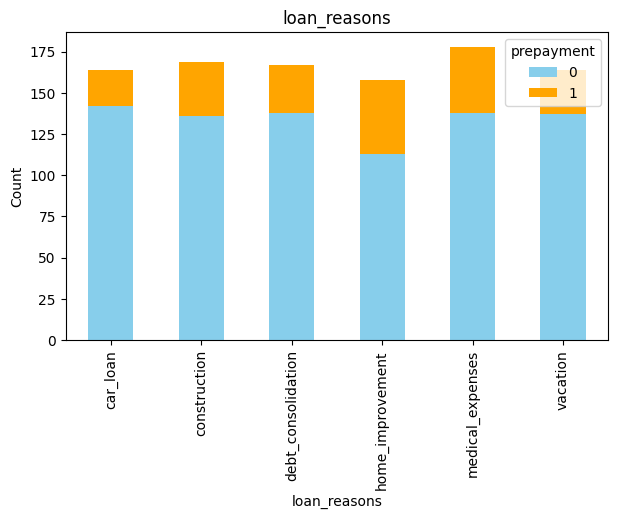

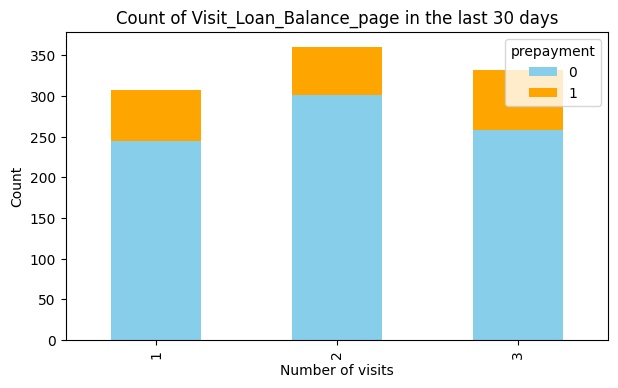

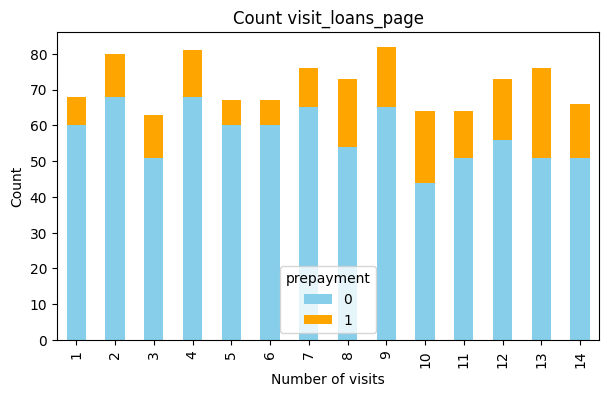

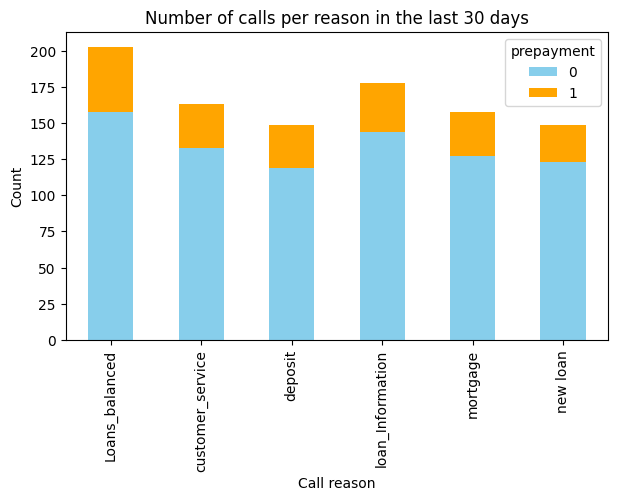

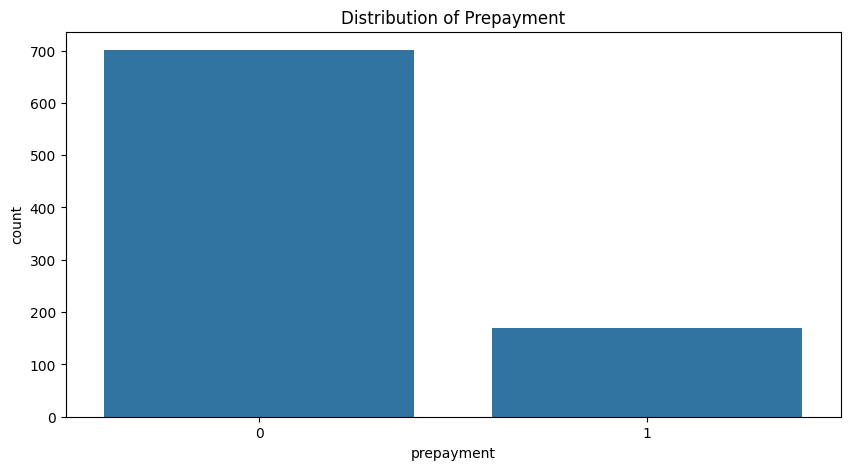

,Feature,Explanation
0,monthly_pay_to_monthly_income,Ratio of monthly loan payment to monthly income.
1,prop_visits_deposit,prop_visits_deposit
2,prop_time_deposit,prop_time_deposit
3,time_surfing_deposit_ratio,Ratio of time spent on the deposit page to tot...
4,total_visit_duration,"Total duration of all visits (deposit, loans, ..."
5,loan_amount_to_income_ratio,Ratio of loan amount to annual income.


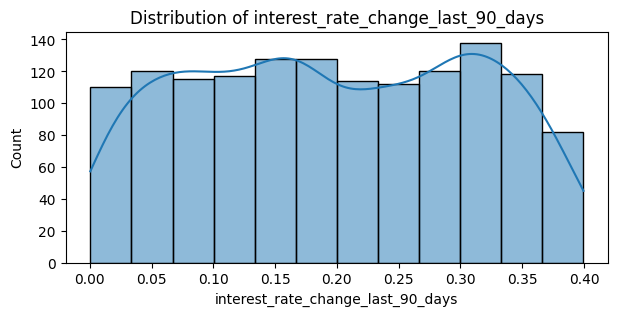

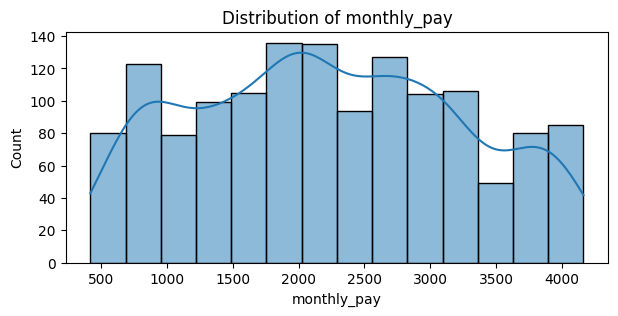

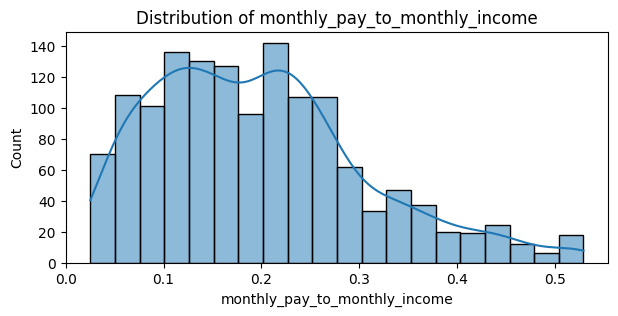

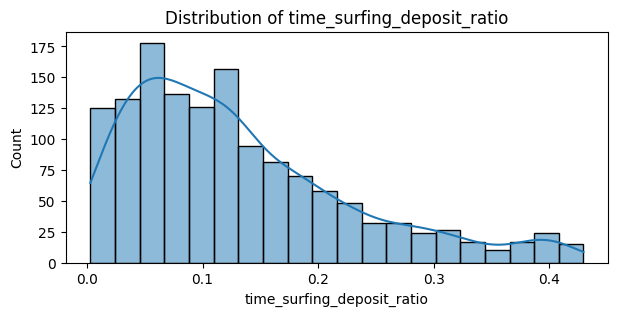

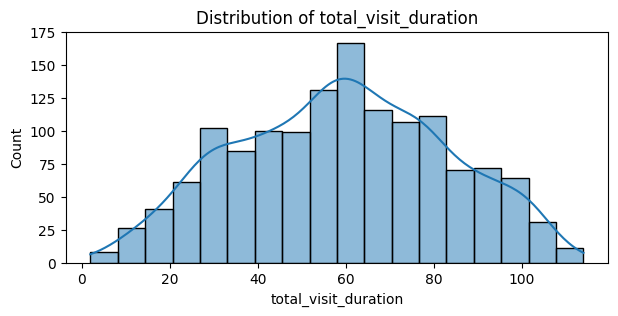

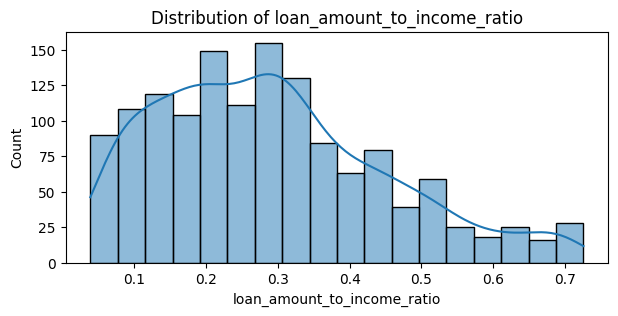

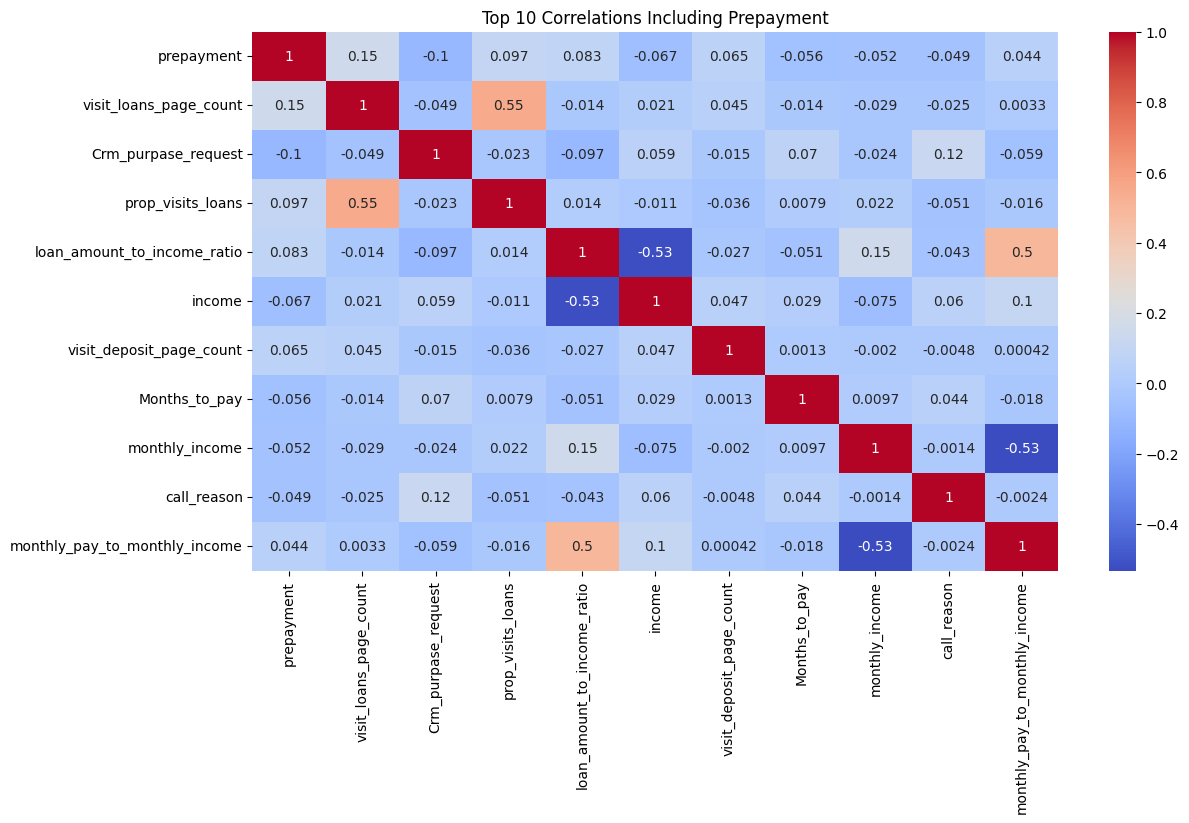

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       207
           1       0.93      0.96      0.95       214

    accuracy                           0.95       421
   macro avg       0.95      0.95      0.95       421
weighted avg       0.95      0.95      0.95       421



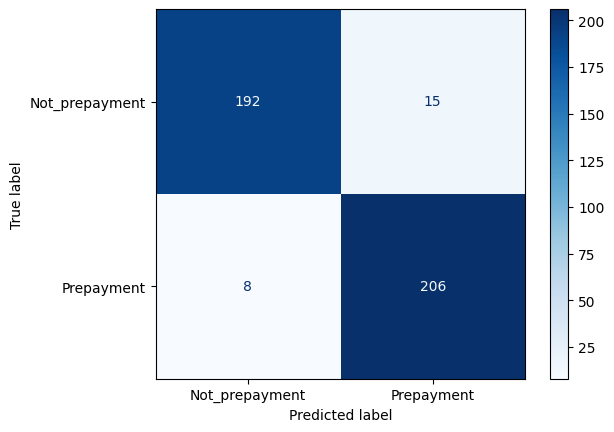

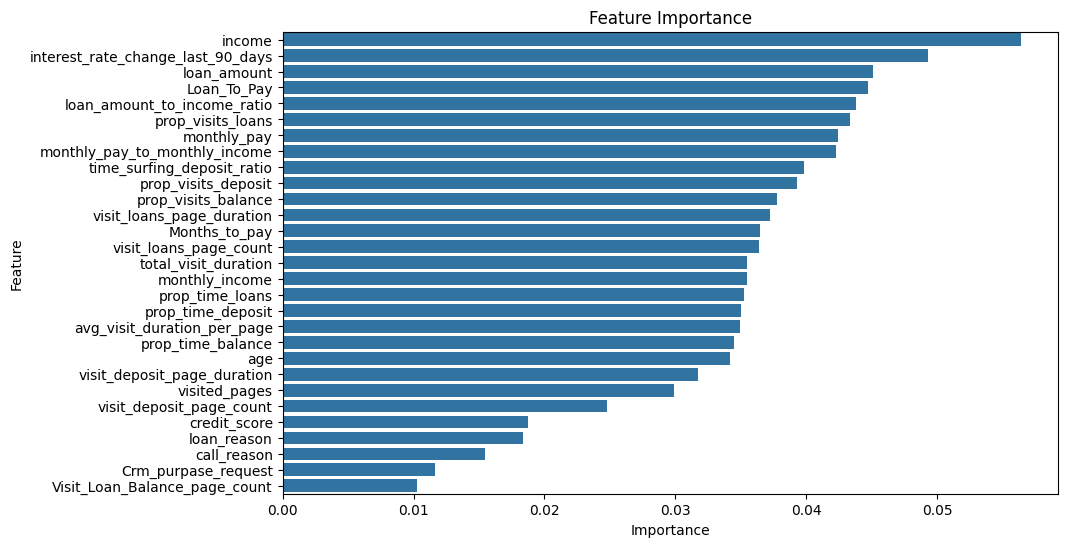

customer_id                         -0.046443
Months_to_pay                       -0.048549
Loan_To_Pay                         -0.043780
Crm_purpase_request                 -0.078951
loan_reason                          0.044204
age                                  0.003192
income                              -0.026105
loan_amount                          0.015368
credit_score                        -0.030377
visited_pages                       -0.006067
call_reason                         -0.036630
monthly_income                      -0.022006
visit_deposit_page_count             0.027613
visit_deposit_page_duration         -0.007460
visit_loans_page_duration           -0.001338
visit_loans_page_count               0.121033
Visit_Loan_Balance_page_count        0.025232
interest_rate_change_last_90_days   -0.004137
prepayment                           1.000000
monthly_pay                          0.015364
monthly_pay_to_monthly_income        0.015574
time_surfing_deposit_ratio        

,Months_to_pay,Loan_To_Pay,Crm_purpase_request,loan_reason,age,income,loan_amount,credit_score,visited_pages,call_reason,...,total_visit_duration,avg_visit_duration_per_page,loan_amount_to_income_ratio,prop_visits_deposit,prop_visits_loans,prop_visits_balance,prop_time_deposit,prop_time_loans,prop_time_balance,Is_Prepayment
628,33,311,1,1,25,124102,9078,7,10,1,...,60,6.000000,0.073150,1.700000,1.300000,0.100000,0.350000,0.650000,0.650000,1
673,43,59,0,4,18,92788,49231,8,44,0,...,35,0.795455,0.530575,0.045455,0.136364,0.068182,0.657143,0.342857,0.342857,1
67,90,34,0,5,65,79943,16989,9,41,4,...,87,2.121951,0.212514,0.317073,0.195122,0.048780,0.448276,0.551724,0.551724,0
25,38,303,0,3,51,129832,45446,3,26,5,...,33,1.269231,0.350037,0.461538,0.461538,0.076923,0.696970,0.303030,0.303030,1
123,45,249,0,3,20,74170,34631,6,34,0,...,64,1.882353,0.466914,0.470588,0.294118,0.088235,0.750000,0.250000,0.250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,97,411,2,1,64,94516,46347,6,21,5,...,81,3.857143,0.490361,0.095238,0.285714,0.095238,0.407407,0.592593,0.592593,0
218,84,437,2,0,39,142789,18699,7,9,1,...,38,4.222222,0.130955,0.777778,1.111111,0.111111,0.552632,0.447368,0.447368,1
536,107,370,0,2,23,85618,22793,8,31,3,...,97,3.129032,0.266217,0.516129,0.129032,0.096774,0.463918,0.536082,0.536082,1
437,92,11,1,3,24,112522,36308,3,28,3,...,58,2.071429,0.322675,0.535714,0.214286,0.107143,0.068966,0.931034,0.931034,0


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import joblib

# Table of Contents
def print_table_of_contents():
    toc = """
    Table of Contents:
    1. Import Data
    2. Feature Engineering
    3. Outlier Detection and Removal
    4. Feature Engineering Explanations
    5. Data Balancing
    6. Exploratory Data Analysis (EDA)
    7. Model Training
    8. Model Evaluation
    9. Feature Importance
    10. Save the Model
    11.Deploy
    """
    print(toc)

print_table_of_contents()

# Set random seed for reproducibility
np.random.seed(42)

# Define number of samples
num_samples = 1000
num_samples = 1000

# Lists of categorical variables
loan_reasons = ['debt_consolidation', 'home_improvement', 'car_loan', 'medical_expenses', 'vacation', 'construction']
call_reasons = ['Loans_balanced', 'loan_Information', 'new loan', 'mortgage', 'deposit', 'customer_service']
crm_purpose = ['Bargain', 'Amount_Left_To_Pay', 'Time_Left_To_Pay']

# Data dictionary
data = {
    'customer_id': np.arange(1, num_samples + 1),
    'Months_to_pay': np.random.randint(1, 120, num_samples),
    'Loan_To_Pay': np.random.randint(1, 450, num_samples),
    'Crm_purpase_request': np.random.choice(crm_purpose, num_samples),
    'loan_reason': np.random.choice(loan_reasons, num_samples),
    'age': np.random.randint(18, 70, num_samples),
    'income': np.random.randint(50000, 150000, num_samples),
    'loan_amount': np.random.randint(5000, 50000, num_samples),
    'credit_score': np.random.randint(1, 10, num_samples),
    'surfing_time': np.random.randint(50, 500, num_samples),
    'visited_pages': np.random.randint(5, 50, num_samples),
    'call_reason': np.random.choice(call_reasons, num_samples),
    'monthly_income': np.random.randint(5000, 20000, num_samples),
    'visit_deposit_page_count': np.random.randint(1, 20, num_samples),
    'visit_deposit_page_duration': np.random.randint(1, 60, num_samples),
    'visit_loans_page_duration': np.random.randint(1, 60, num_samples),
    'visit_loans_page_count': np.random.randint(1, 15, num_samples),
    'Visit_Loan_Balance_page_count': np.random.randint(1, 4, num_samples),
    'interest_rate_change_last_90_days': np.random.uniform(0, 0.4, num_samples),
    'prepayment': np.random.choice([0, 1], num_samples, p=[0.8, 0.2])  # 80% not prepaid, 20% prepaid
}

# Introduce moderate correlations
# Positive correlation features
for i in range(num_samples):
    if data['prepayment'][i] == 1:
        if np.random.rand() < 0.1:  # 10% chance to adjust to create moderate correlation
            data['Visit_Loan_Balance_page_count'][i] = np.random.randint(3, 4)  # Higher balance count
            data['visit_loans_page_count'][i] = np.random.randint(10, 15)  # Higher loans count
            data['Crm_purpase_request'][i] = 'Amount_Left_To_Pay'  # Set a specific CRM purpose sometimes
            data['loan_reason'][i] = 'home_improvement'  # Set a specific loan reason sometimes
            data['call_reason'][i] = 'Loans_balanced'  # Set a specific call reason sometimes

# Negative correlation features
for i in range(num_samples):
    if data['prepayment'][i] == 0:
        if np.random.rand() < 0.1:  # 10% chance to adjust to create negative correlation
            data['Loan_To_Pay'][i] = np.random.randint(350, 450)  # Higher loan to pay
            data['Months_to_pay'][i] = np.random.randint(80, 120)  # Longer months to pay

# Calculate monthly pay assuming a simple interest model with fixed monthly payments
data['monthly_pay'] = data['loan_amount'] * (1 + data['interest_rate_change_last_90_days'] / 100) / 12

# Convert to DataFrame
df = pd.DataFrame(data)

# Feature Engineering
def feature_engineering(df):
    df['monthly_pay_to_monthly_income'] = df['monthly_pay'] / df['monthly_income']
    df['time_surfing_deposit_ratio'] = df['visit_deposit_page_duration'] / df['surfing_time']
    df['total_visit_duration'] = df['visit_deposit_page_duration'] + df['visit_loans_page_duration']
    df['avg_visit_duration_per_page'] = df['total_visit_duration'] / df['visited_pages']
    df['loan_amount_to_income_ratio'] = df['loan_amount'] / df['income']
    df['prop_visits_deposit'] = df['visit_deposit_page_count'] / df['visited_pages']
    df['prop_visits_loans'] = df['visit_loans_page_count'] / df['visited_pages']
    df['prop_visits_balance'] = df['Visit_Loan_Balance_page_count'] / df['visited_pages']
    df['prop_time_deposit'] = df['visit_deposit_page_duration'] / df['total_visit_duration']
    df['prop_time_loans'] = df['visit_loans_page_duration'] / df['total_visit_duration']
    df['prop_time_balance'] = df['visit_loans_page_duration'] / df['total_visit_duration']
    return df

df = feature_engineering(df)
from sklearn.preprocessing import LabelEncoder


# Group by Category and count occurrences of 1s and 0s
count_data = df.groupby(['loan_reason', 'prepayment']).size().unstack(fill_value=0)
# Plot the stacked bar chart
ax = count_data.plot(kind='bar', stacked=True, figsize=(7, 4), color=['skyblue', 'orange'])
# Set the title and labels
ax.set_title('loan_reasons')
ax.set_xlabel('loan_reasons')
ax.set_ylabel('Count')
# Show the plot
plt.show()


# Group by Category and count occurrences of 1s and 0s
count_data = df.groupby(['Visit_Loan_Balance_page_count', 'prepayment']).size().unstack(fill_value=0)
# Plot the stacked bar chart
ax = count_data.plot(kind='bar', stacked=True, figsize=(7, 4), color=['skyblue', 'orange'])
# Set the title and labels
ax.set_title('Count of Visit_Loan_Balance_page in the last 30 days')
ax.set_xlabel('Number of visits')
ax.set_ylabel('Count')
# Show the plot
plt.show()


# Group by Category and count occurrences of 1s and 0s
count_data = df.groupby(['visit_loans_page_count', 'prepayment']).size().unstack(fill_value=0)
# Plot the stacked bar chart
ax = count_data.plot(kind='bar', stacked=True, figsize=(7, 4), color=['skyblue', 'orange'])
# Set the title and labels
ax.set_title('Count visit_loans_page')
ax.set_xlabel('Number of visits')
ax.set_ylabel('Count')
# Show the plot
plt.show()

# Group by Category and count occurrences of 1s and 0s
count_data = df.groupby(['call_reason', 'prepayment']).size().unstack(fill_value=0)
# Plot the stacked bar chart
ax = count_data.plot(kind='bar', stacked=True, figsize=(7, 4), color=['skyblue', 'orange'])
# Set the title and labels
ax.set_title('Number of calls per reason in the last 30 days')
ax.set_xlabel('Call reason')
ax.set_ylabel('Count')
# Show the plot
plt.show()



label_encoder = LabelEncoder()
df['loan_reason'] = label_encoder.fit_transform(df['loan_reason'])
df['Crm_purpase_request'] = label_encoder.fit_transform(df['Crm_purpase_request'])
df['call_reason'] = label_encoder.fit_transform(df['call_reason'])

del  df['surfing_time']
# Outlier Detection and Removal using IQR method
def remove_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

numerical_features = ['age', 'income', 'loan_amount', 'credit_score',
                      'monthly_income', 'interest_rate_change_last_90_days', 'monthly_pay', 'monthly_pay_to_monthly_income',
                      'time_surfing_deposit_ratio', 'total_visit_duration',
                      'loan_amount_to_income_ratio']

df = remove_outliers(df, numerical_features)

# Create a table for feature engineering explanations
new_features = ['monthly_pay_to_monthly_income','prop_visits_deposit','prop_time_deposit', 'time_surfing_deposit_ratio', 'total_visit_duration',
               'loan_amount_to_income_ratio']
feature_explanations = {
    "Feature": new_features,
    "Explanation": [
        "Ratio of monthly loan payment to monthly income.",
        "prop_visits_deposit",
        "prop_time_deposit",
        "Ratio of time spent on the deposit page to total time spent on the website.",
        "Total duration of all visits (deposit, loans, and mortgage pages).",
        "Ratio of loan amount to annual income."
    ]
}


# Plot distributions of target variable
plt.figure(figsize=(10, 5))
sns.countplot(x='prepayment', data=df)
plt.title('Distribution of Prepayment')
plt.show()

explanation_df = pd.DataFrame(feature_explanations)

display(explanation_df)

# Convert categorical features to numerical using one-hot encoding
#df = pd.get_dummies(df, columns=text_list)

# Balance the dataset using oversampling
df_majority = df[df['prepayment'] == 0]
df_minority = df[df['prepayment'] == 1]



df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Perform EDA
def perform_eda(df):
    # Plot distributions of numerical features
    numerical_features = ['interest_rate_change_last_90_days', 'monthly_pay', 'monthly_pay_to_monthly_income',
                          'time_surfing_deposit_ratio', 'total_visit_duration',
                          'loan_amount_to_income_ratio']

    for feature in numerical_features:
        plt.figure(figsize=(7, 3))
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.show()

    # Plot the correlation matrix
    corr_matrix = df.corr().abs()
    top_corr_features = corr_matrix.nlargest(11, 'prepayment')['prepayment'].index
    top_corr_matrix = df[top_corr_features].corr()

    plt.figure(figsize=(13, 7))
    sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Top 10 Correlations Including Prepayment')
    plt.show()



perform_eda(df_balanced)

# Split the data into training and testing sets
X = df_balanced.drop(['customer_id', 'prepayment'], axis=1)
y = df_balanced['prepayment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Not_prepayment', 'Prepayment']
)




# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Save the trained model to a file
joblib.dump(model, 'loan_prepayment_model.pkl')
display(df.corr().prepayment)






X_test=pd.DataFrame(X_test)
X_test['Is_Prepayment']=y_pred
display(X_test)
